In [16]:
# Confirm that the version pymc is 4 or greater
import pymc as pm
print(pm.__version__)

5.27.1


If one of the following are not installed, install using the following command: !conda install seaborn -y

In [17]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import arviz as az # dedicated, platform-agnostic package to handle PyMC’s plotting and diagnostics functionalities
import pytensor.tensor as pt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss

In [34]:
# Load Dataset:
try:
    dataset = pd.read_csv('Tweets.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'Tweets.csv' was not found.")
    
except pd.errors.EmptyDataError:
    print("Error: The file 'Tweets.csv' is empty.")
    
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. It might be corrupted.")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset loaded successfully!


In [35]:
# Very Basic EDA:
print(f"Dataset Shape: {dataset.shape}")
print(f"\nNumber of Features in Train: {dataset.shape[1]}")
print("\n" + "=" * 60)
print("\n" ,{dataset.info()})
print("\n" + "=" * 60)
missing = dataset.isnull().sum()
missing_pct = (missing / len(dataset)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Percentage': missing_pct.values
    }).query('Missing_Count > 0').sort_values('Percentage', ascending=False)   
print("\nMissing Values:")
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
print("\n" + "=" * 60)

print("Full row duplicates:", dataset.duplicated().sum())
print("Duplicate tweet_id:", dataset['tweet_id'].duplicated().sum())
print("Duplicate text:", dataset['text'].duplicated().sum())


Dataset Shape: (14640, 15)

Number of Features in Train: 15

<class 'pandas.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  str    
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   str    
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  str    
 6   airline_sentiment_gold        40 non-null     str    
 7   name                          14640 non-null  str    
 8   negativereason_gold           32 non-null     str    
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  str    
 11  tweet_coord                   1019 non-null   str    
 12  tweet_crea

In [36]:
# Drop full row duplicates, keep first occurence
dataset = dataset.drop_duplicates(keep="first")

# Keep the row with the most information for duplicate tweet id's
dataset["_non_nulls"] = dataset.notna().sum(axis=1)
dataset = (dataset.sort_values(["tweet_id", "_non_nulls"], ascending=[True, False])
                    .drop_duplicates(subset=["tweet_id"], keep="first")
                    .drop(columns=["_non_nulls"]))

print("Full row duplicates:", dataset.duplicated().sum())
print("Duplicate tweet_id:", dataset['tweet_id'].duplicated().sum())
print("Duplicate text:", dataset['text'].duplicated().sum())
print(f"Dataset Shape: {dataset.shape}")


Full row duplicates: 0
Duplicate tweet_id: 0
Duplicate text: 58
Dataset Shape: (14485, 15)


Keeping the duplicate text as it might be important for retweet probability, identitical texts might have different retweet ooutcomes. 

In [37]:
# Target Distribution
dataset["y_retweeted"] = (dataset["retweet_count"] >= 1).astype(int)
print(dataset["y_retweeted"].value_counts())

print("\n" + "=" * 60)

# Basic Summary per Airline
airline_stats = (dataset.groupby("airline").agg(
          total_retweets=("retweet_count", "sum"),
          mean_retweets=("retweet_count", "mean"),
          tweet_count=("retweet_count", "count"),
          retweet_rate=("y_retweeted", "mean")).sort_values("retweet_rate", ascending=False))

print(airline_stats)

print("\n" + "=" * 60)

# Total Retweet Counts per Sentiment
retweets_by_sentiment = (dataset.groupby("airline_sentiment")["retweet_count"].sum().sort_values(ascending=False))

# Total Retweet Counts per Negative Reason
retweets_by_reason = (dataset[dataset["airline_sentiment"] == "negative"].groupby("negativereason")["retweet_count"].sum().sort_values(ascending=False))

print("How many total retweets were generated by tweets of each sentiment?\n", retweets_by_sentiment)
print("\n" + "=" * 60)
print("Of the negative sentiment, which reasons were retweeted?\n", retweets_by_reason)

y_retweeted
0    13720
1      765
Name: count, dtype: int64

                total_retweets  mean_retweets  tweet_count  retweet_rate
airline                                                                 
United                     421       0.110152         3822      0.099163
Delta                      252       0.113411         2222      0.041404
US Airways                 249       0.085479         2913      0.040851
Southwest                  145       0.059917         2420      0.035537
Virgin America              26       0.051587          504      0.029762
American                   115       0.044163         2604      0.028418

How many total retweets were generated by tweets of each sentiment?
 airline_sentiment
negative    855
neutral     189
positive    164
Name: retweet_count, dtype: int64

Of the negative sentiment, which reasons were retweeted?
 negativereason
Customer Service Issue         220
Can't Tell                     219
Late Flight                    155
Cancel

Dataset is imbalanced with this target, retweet event is rare. Keep this in mind for metric evaluation.
Target: 1: retweeted by any number of times greater than 1. 0 if not retweeted.

In [41]:
Train = dataset.copy()
Train["text_len"] = Train["text"].astype(str).str.len()

# Select features to use
feature_cols = [
    "airline_sentiment_confidence",
    "airline",
    "text_len",
    "airline_sentiment"
]
num_cols = ["airline_sentiment_confidence", "text_len"]

Train_raw = Train[feature_cols].copy()

# One-hot encode categoricals
X = pd.get_dummies(Train_raw, columns=["airline", "airline_sentiment"], drop_first=True)

# Convert booleans to ints if any appear
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

y = Train["y_retweeted"].astype(int)

# Split train and test so we can evaluate, use stratify for target imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Standardize numeric columns using train stats
means = X_train[num_cols].mean()
stds = X_train[num_cols].std().replace(0, 1)

X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[num_cols] = (X_train_std[num_cols] - means) / stds
X_test_std[num_cols] = (X_test_std[num_cols] - means) / stds

N, D = X_train_std.shape
# Expected number of important predictors
D0 = int(D / 2)

N, D, D0

(11588, 9, 4)

In [42]:
X_train_std

,airline_sentiment_confidence,text_len,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,airline_sentiment_neutral,airline_sentiment_positive
6598,-1.287187,0.005264,0,1,0,0,0,0,0
1470,0.610975,-0.712350,0,0,0,1,0,0,1
14249,0.610975,0.971282,0,0,0,0,0,0,0
293,0.610975,-0.850352,0,0,0,0,1,0,1
10628,0.610975,0.667676,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1905,-1.472957,0.170867,0,0,0,1,0,1,0
5396,0.610975,0.805679,0,1,0,0,0,0,1
4173,-1.556952,-0.601948,0,0,0,1,0,1,0
13597,-1.429427,-0.546747,0,0,0,0,0,0,0


The model: A Bayesian logistic regression that uses the hierarchical regularized horseshoe as a shirnkage prior as\
in the Educational Outcomes for Hearing-impaired Children example

Assess how other features (see below) correlate and affect the target. For this model, keeping it simple. 
- Time of the day
- Day of the week
- Has URL
- Has mention @

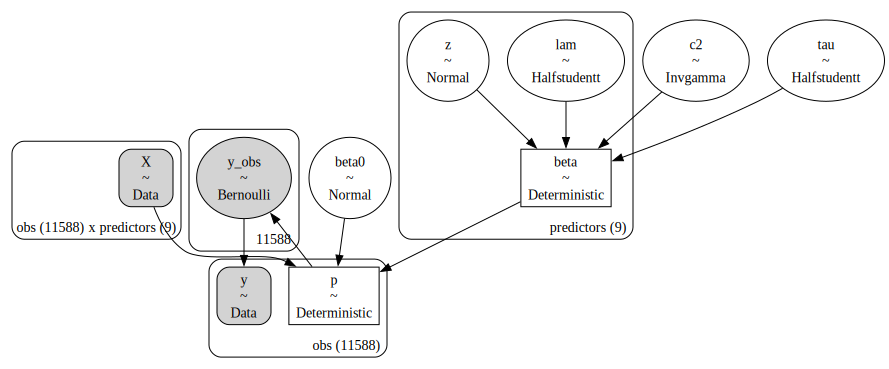

In [43]:
coords = {"predictors": X_train_std.columns.values}

with pm.Model(coords=coords) as rt_model:
    # Data containers so we can swap train/test later
    X_data = pm.Data("X", X_train_std.values, dims=("obs", "predictors"))
    y_data = pm.Data("y", y_train.values, dims=("obs",))

    # Compute log-odds of base rate
    base_rate = y_train.mean()
    logit_base = np.log(base_rate / (1 - base_rate))
    logit_base

    # Prior on (logit) intercept: 
    beta0 = pm.Normal("beta0", mu=logit_base, sigma=1.0)

    # Regularized horseshoe priors (from example)
    tau = pm.HalfStudentT("tau", nu=2, sigma=D0 / (D - D0) / np.sqrt(N)) # Global shrinkage prior
    lam = pm.HalfStudentT("lam", nu=5, sigma=1.0, dims="predictors") # Local shrinkage prior
    c2 = pm.InverseGamma("c2", alpha=1, beta=1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    
    beta = pm.Deterministic("beta", z * tau * lam * pt.sqrt(c2 / (c2 + (tau**2) * (lam**2))),dims="predictors")

    # Linear predictor + logistic link
    eta = beta0 + pt.dot(X_data, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims="obs")

    # Likelihood - ensures probabilities remain in [0,1] because retweet occurrence is binary
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

pm.model_to_graphviz(rt_model)

Sampling: [beta0, c2, lam, tau, y_obs, z]


Observed train positive rate: 0.052813255091473936
Simulated prior positive rate: <xarray.DataArray 'y_obs' ()> Size: 8B
array(0.07799206)


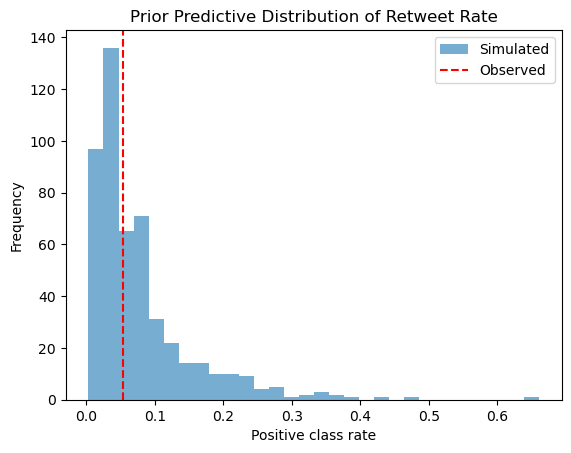

In [44]:
with rt_model:
    prior = pm.sample_prior_predictive(samples=500, random_seed=7)

obs_rate = y_train.mean()
sim_rate = prior.prior_predictive["y_obs"].mean(axis=0).mean()

print("Observed train positive rate:", obs_rate) 
print("Simulated prior positive rate:", sim_rate)

# Extract numpy array
y_prior = prior.prior_predictive["y_obs"].values  # shape: (chain, draw, obs)

# Combine chain + draw
y_prior_flat = y_prior.reshape(-1, y_prior.shape[-1])

# Compute positive rate per prior sample
prior_rates = y_prior_flat.mean(axis=1)

plt.hist(prior_rates, bins=30, alpha=0.6, label="Simulated")
plt.axvline(obs_rate, color="red", linestyle="--", label="Observed")
plt.xlabel("Positive class rate")
plt.ylabel("Frequency")
plt.legend()
plt.title("Prior Predictive Distribution of Retweet Rate")
plt.show()

In [45]:
with rt_model:
    idata = pm.sample(
        draws=1000,
        tune=2000,
        random_seed=7,
        target_accept=0.95,
        chains=4
    )

C:\ProgramData\miniconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, tau, lam, c2, z]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 320 seconds.


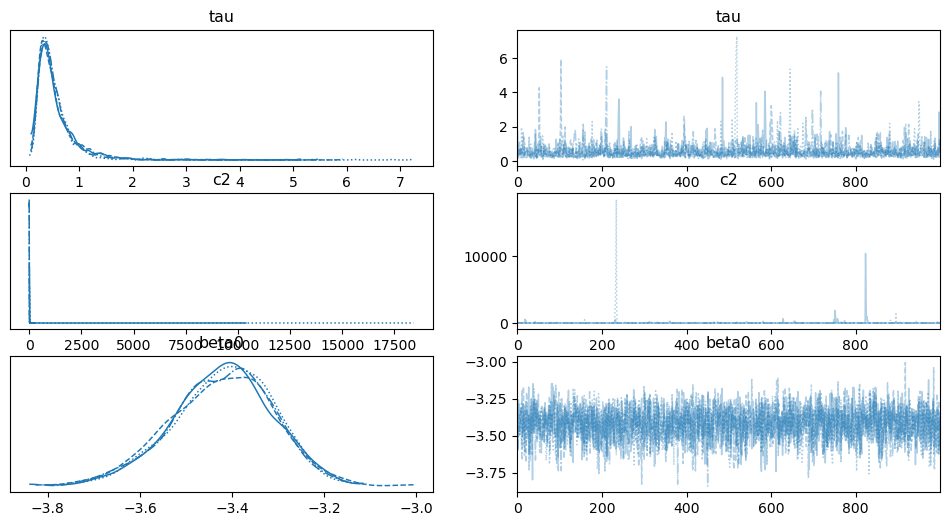

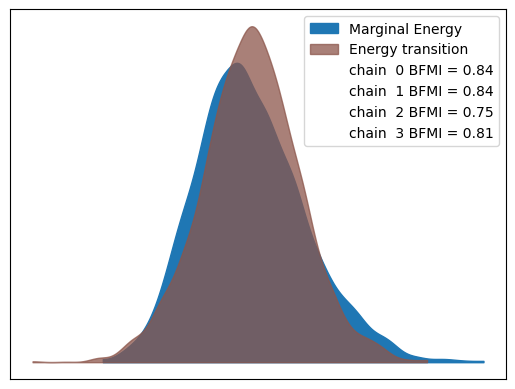

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.421,0.109,-3.634,-3.227,0.002,0.002,2512.0,2510.0,1.0
tau,0.562,0.456,0.140,1.203,0.012,0.044,1673.0,2098.0,1.0
c2,21.905,382.613,0.205,18.117,9.910,148.151,1692.0,1268.0,1.0


In [46]:
az.plot_trace(idata, var_names=["tau", "c2", "beta0"])
plt.show()

az.plot_energy(idata)
plt.show()

az.summary(idata, var_names=["beta0", "tau", "c2"])

predictors
airline_sentiment_confidence    0.188387
text_len                        0.319428
airline_Delta                   0.513476
airline_Southwest               0.058252
airline_US Airways              0.110159
airline_United                  1.229889
airline_Virgin America          0.083891
airline_sentiment_neutral      -0.442613
airline_sentiment_positive     -0.222090
Name: beta, dtype: float64
['airline_United', 'airline_Delta', 'airline_sentiment_neutral', 'text_len', 'airline_sentiment_positive', 'airline_sentiment_confidence', 'airline_US Airways', 'airline_Virgin America', 'airline_Southwest']


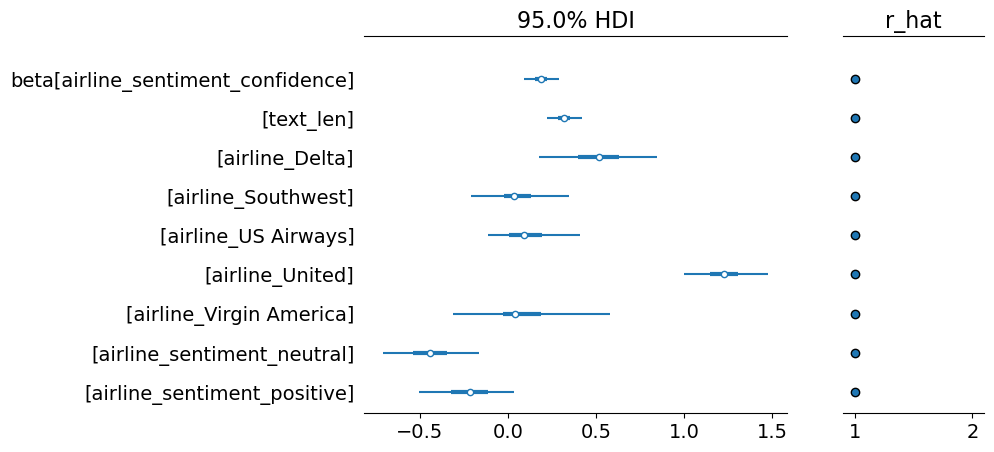

In [51]:
# Get posterior means of beta to pick top absolute effects
beta_post = idata.posterior["beta"].mean(("chain", "draw")).to_series()
top = beta_post.abs().sort_values(ascending=False).head(20).index.tolist()
print(beta_post)
print(top)

az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);
plt.show()

In [48]:
with rt_model:
    pm.set_data({"X": X_test_std.values, "y": y_test.values})
    post_pred = pm.sample_posterior_predictive(idata, var_names=["p", "y_obs"], random_seed=7)

# Posterior mean probability per observation
p_test = post_pred.posterior_predictive["p"].mean(("chain", "draw")).values

print("ROC AUC:", roc_auc_score(y_test, p_test))
print("PR AUC :", average_precision_score(y_test, p_test))
print("Brier :", brier_score_loss(y_test, p_test))
print("LogLoss:", log_loss(y_test, p_test))

Sampling: [y_obs]


Output()

ROC AUC: 0.6498182606375884
PR AUC : 0.1072541233941324
Brier : 0.04905460743520089
LogLoss: 0.19910457285018587


References and Reading:
- https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
- https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html
- https://towardsdatascience.com/a-gentle-introduction-to-bayesian-inference-6a7552e313cb/?source=post_page-----d407f8d934a5---------------------------------------
- https://towardsdatascience.com/beginner-friendly-bayesian-inference-2e2839a9ae18/?source=post_page-----d407f8d934a5---------------------------------------
- https://www.pymc.io/projects/examples/en/latest/statistical_rethinking_lectures/09-Modeling_Events.html
- https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a/


In [ ]:
Conclusion: 
